# # Global Token + One Mask Token (Anomaly Scoring = Softmax)

## ## 000.png

In [ ]:
import torch, math
from pathlib import Path
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

MASK_PT  = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/hole/000_siglip_tokens.pt")
GLOB_PT  = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_global/hazelnut/hole/000_global_token.pt")
MODEL_ID = "llava-hf/llava-onevision-qwen2-7b-ov-hf"

DEV   = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.bfloat16                                       

In [ ]:
proc  = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
model = LlavaOnevisionForConditionalGeneration.from_pretrained(
            MODEL_ID,
            torch_dtype       = DTYPE,
            device_map        = "auto",
            low_cpu_mem_usage = True,
            trust_remote_code = True
        ).eval()
TOK_IMG   = proc.tokenizer.additional_special_tokens[0]      
YES_ID, NO_ID = [proc.tokenizer.encode(w, add_special_tokens=False)[0] for w in ("yes", "no")]

In [6]:
d_mask = torch.load(MASK_PT, map_location="cpu", weights_only=False)
g_tok  = torch.load(GLOB_PT, map_location="cpu", weights_only=False)["global_token"] 

mask_tokens = d_mask["mask_token"]                           

In [7]:
for j, m_tok in enumerate(mask_tokens):                       
    vis_tok = torch.cat([g_tok.unsqueeze(0), m_tok.unsqueeze(0)], dim=0)  

    v_emb = model.multi_modal_projector(vis_tok.unsqueeze(0).to(DEV, DTYPE))  

    prompt = f"{TOK_IMG} {TOK_IMG} USER: Is there any anomaly in the image? (Yes / No)\nASSISTANT:"
    tok_in = proc.tokenizer(prompt, return_tensors="pt").to(DEV)
    t_emb  = model.get_input_embeddings()(tok_in.input_ids).to(DTYPE)

    inp_emb  = torch.cat([v_emb, t_emb], dim=1)                     
    att_mask = torch.cat([torch.ones(1, 2, device=DEV, dtype=torch.long),
                          tok_in.attention_mask], dim=1)

    with torch.no_grad():
        out = model(inputs_embeds=inp_emb, attention_mask=att_mask, use_cache=False)
        logits = out.logits[0, -1]                                  

    p_yes = torch.softmax(logits[[YES_ID, NO_ID]], dim=0)[0].item()
    p_no  = 1 - p_yes
    print(f"[mask {j:02d}]   yes={p_yes:.4f}   no={p_no:.4f}")

[mask 00]   yes=0.6523   no=0.3477
[mask 01]   yes=0.6602   no=0.3398
[mask 02]   yes=0.6719   no=0.3281
[mask 03]   yes=0.6523   no=0.3477
[mask 04]   yes=0.6719   no=0.3281
[mask 05]   yes=0.6641   no=0.3359
[mask 06]   yes=0.6641   no=0.3359
[mask 07]   yes=0.6602   no=0.3398


마스크 개수: 8
  • mask 00: 1024×1024  픽셀수=15
  • mask 01: 1024×1024  픽셀수=13033
  • mask 02: 1024×1024  픽셀수=2849
  • mask 03: 1024×1024  픽셀수=50
  • mask 04: 1024×1024  픽셀수=642250
  • mask 05: 1024×1024  픽셀수=310767
  • mask 06: 1024×1024  픽셀수=89367
  • mask 07: 1024×1024  픽셀수=90439


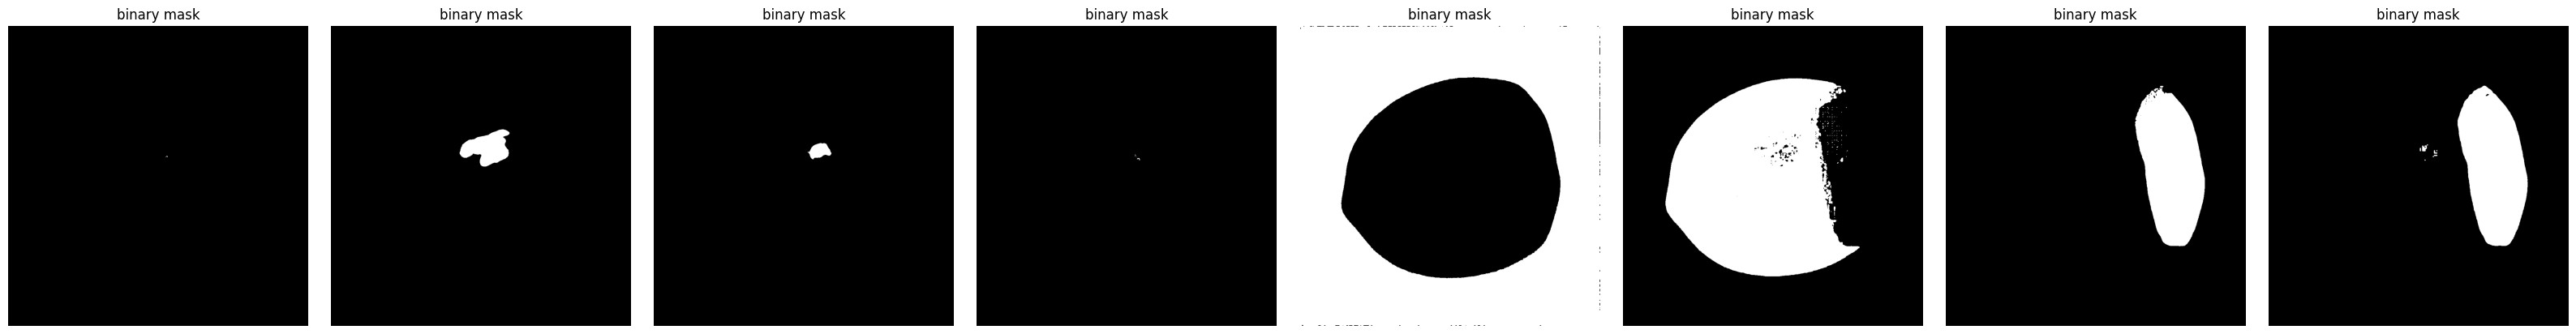

In [22]:
import torch, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

MASK_PT = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/hole/000_siglip_tokens.pt")
IMG_PNG = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/hole/000.png")

data  = torch.load(MASK_PT, map_location="cpu", weights_only=False)
masks = data["mask"]                       

print(f"마스크 개수: {len(masks)}")
for i, m in enumerate(masks):
    h, w = m.shape
    print(f"  • mask {i:02d}: {h}×{w}  픽셀수={m.sum()}")

n_show = len(masks)                
fig, axes = plt.subplots(1, n_show, figsize=(4*n_show, 4))
if n_show == 1:
    axes = [axes]

for ax, seg in zip(axes, masks[:n_show]):
    ax.imshow(seg, cmap="gray")
    ax.set_title("binary mask")
    ax.axis("off")

plt.tight_layout()
plt.show()

## ## 001.png

In [1]:
import torch, math
from pathlib import Path
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

MASK_PT  = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/hole/001_siglip_tokens.pt")
GLOB_PT  = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token_demo/hazelnut/hole/good/001_global_token.pt")
MODEL_ID = "llava-hf/llava-onevision-qwen2-7b-ov-hf"

DEV   = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.bfloat16                                       

In [ ]:
proc  = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
model = LlavaOnevisionForConditionalGeneration.from_pretrained(
            MODEL_ID,
            torch_dtype       = DTYPE,
            device_map        = "auto",
            low_cpu_mem_usage = True,
            trust_remote_code = True
        ).eval()
TOK_IMG   = proc.tokenizer.additional_special_tokens[0]      
YES_ID, NO_ID = [proc.tokenizer.encode(w, add_special_tokens=False)[0] for w in ("yes", "no")]

In [3]:
d_mask = torch.load(MASK_PT, map_location="cpu", weights_only=False)
g_tok  = torch.load(GLOB_PT, map_location="cpu", weights_only=False)["global_token"]  

mask_tokens = d_mask["mask_token"]                            

In [4]:
for j, m_tok in enumerate(mask_tokens):                        
    vis_tok = torch.cat([g_tok.unsqueeze(0), m_tok.unsqueeze(0)], dim=0)  

    v_emb = model.multi_modal_projector(vis_tok.unsqueeze(0).to(DEV, DTYPE))  

    prompt = f"{TOK_IMG} {TOK_IMG} USER: Is there any anomaly in the image? (Yes / No)\nASSISTANT:"
    tok_in = proc.tokenizer(prompt, return_tensors="pt").to(DEV)
    t_emb  = model.get_input_embeddings()(tok_in.input_ids).to(DTYPE)

    inp_emb  = torch.cat([v_emb, t_emb], dim=1)                      
    att_mask = torch.cat([torch.ones(1, 2, device=DEV, dtype=torch.long),
                          tok_in.attention_mask], dim=1)

    with torch.no_grad():
        out = model(inputs_embeds=inp_emb, attention_mask=att_mask, use_cache=False)
        logits = out.logits[0, -1]                                  

    p_yes = torch.softmax(logits[[YES_ID, NO_ID]], dim=0)[0].item()
    p_no  = 1 - p_yes
    print(f"[mask {j:02d}]   yes={p_yes:.4f}   no={p_no:.4f}")

[mask 00]   yes=0.6641   no=0.3359
[mask 01]   yes=0.6602   no=0.3398
[mask 02]   yes=0.6641   no=0.3359
[mask 03]   yes=0.6523   no=0.3477
[mask 04]   yes=0.6641   no=0.3359


마스크 개수: 5
  • mask 00: 1024×1024  픽셀수=3055
  • mask 01: 1024×1024  픽셀수=2
  • mask 02: 1024×1024  픽셀수=689257
  • mask 03: 1024×1024  픽셀수=349502
  • mask 04: 1024×1024  픽셀수=74681


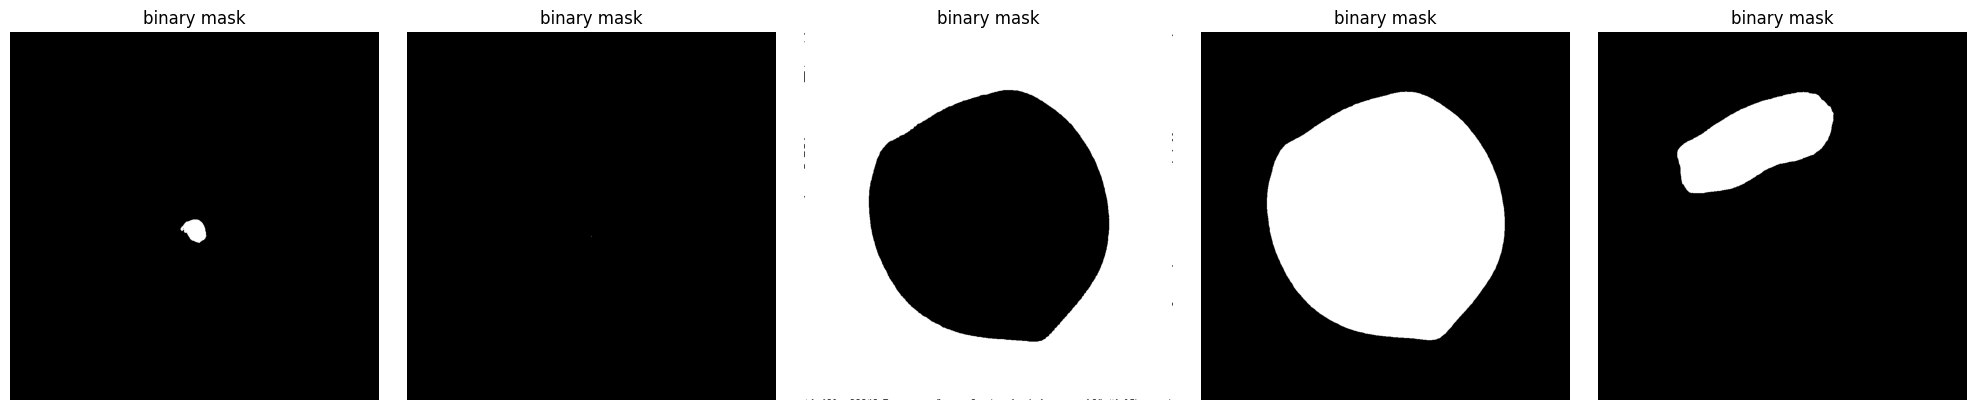

In [21]:
import torch, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

MASK_PT = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/hole/001_siglip_tokens.pt")
IMG_PNG = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/hole/001.png")

data  = torch.load(MASK_PT, map_location="cpu", weights_only=False)
masks = data["mask"]                       

print(f"마스크 개수: {len(masks)}")
for i, m in enumerate(masks):
    h, w = m.shape
    print(f"  • mask {i:02d}: {h}×{w}  픽셀수={m.sum()}")

n_show = len(masks)                
fig, axes = plt.subplots(1, n_show, figsize=(4*n_show, 4))
if n_show == 1:
    axes = [axes]

for ax, seg in zip(axes, masks[:n_show]):
    ax.imshow(seg, cmap="gray")
    ax.set_title("binary mask")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
1 image  · 1 global token · 1 mask token → Yes / No soft-max
"""

import torch, math
from pathlib import Path
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

# ── 경로 설정 ──────────────────────────────────────────
MASK_PT  = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/hole/002_siglip_tokens.pt")
GLOB_PT  = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token_demo/hazelnut/hole/good/002_global_token.pt")
MODEL_ID = "llava-hf/llava-onevision-qwen2-7b-ov-hf"

DEV   = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.bfloat16                                       # Qwen2-7B native dtype

In [ ]:
# ── LLaVA 로드 ─────────────────────────────────────────
proc  = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
model = LlavaOnevisionForConditionalGeneration.from_pretrained(
            MODEL_ID,
            torch_dtype       = DTYPE,
            device_map        = "auto",
            low_cpu_mem_usage = True,
            trust_remote_code = True
        ).eval()

TOK_IMG   = proc.tokenizer.additional_special_tokens[0]      # '<image>'
YES_ID, NO_ID = [proc.tokenizer.encode(w, add_special_tokens=False)[0] for w in ("yes", "no")]

In [3]:
# ── 토큰 로드 ──────────────────────────────────────────
d_mask = torch.load(MASK_PT, map_location="cpu", weights_only=False)
g_tok  = torch.load(GLOB_PT, map_location="cpu", weights_only=False)["global_token"]  # (1152,)

mask_tokens = d_mask["mask_token"]                              # (M,1152)

In [4]:
# ── ① mask 하나씩 soft-max 확인 ───────────────────────
for j, m_tok in enumerate(mask_tokens):                         # loop over M
    vis_tok = torch.cat([g_tok.unsqueeze(0), m_tok.unsqueeze(0)], dim=0)  # (2,1152)

    # Vision projector 1152 ➜ 3584
    v_emb = model.multi_modal_projector(vis_tok.unsqueeze(0).to(DEV, DTYPE))  # (1,2,3584)

    # 프롬프트에 <image> 토큰 2개 삽입
    prompt = f"{TOK_IMG} {TOK_IMG} USER: Is there any anomaly in the image? (Yes / No)\nASSISTANT:"
    tok_in = proc.tokenizer(prompt, return_tensors="pt").to(DEV)
    t_emb  = model.get_input_embeddings()(tok_in.input_ids).to(DTYPE)

    # 인풋 & 마스크
    inp_emb  = torch.cat([v_emb, t_emb], dim=1)                       # (1, 2+L, 3584)
    att_mask = torch.cat([torch.ones(1, 2, device=DEV, dtype=torch.long),
                          tok_in.attention_mask], dim=1)

    # forward (한 스텝, logits만 필요)
    with torch.no_grad():
        out = model(inputs_embeds=inp_emb, attention_mask=att_mask, use_cache=False)
        logits = out.logits[0, -1]                                    # (Vocab,)

    # soft-max 확률
    p_yes = torch.softmax(logits[[YES_ID, NO_ID]], dim=0)[0].item()
    p_no  = 1 - p_yes
    print(f"[mask {j:02d}]   yes={p_yes:.4f}   no={p_no:.4f}")

[mask 00]   yes=0.6641   no=0.3359
[mask 01]   yes=0.6641   no=0.3359
[mask 02]   yes=0.6641   no=0.3359
[mask 03]   yes=0.6602   no=0.3398
[mask 04]   yes=0.6602   no=0.3398
[mask 05]   yes=0.6602   no=0.3398
[mask 06]   yes=0.6641   no=0.3359


마스크 개수: 7
  • mask 00: 1024×1024  픽셀수=6105
  • mask 01: 1024×1024  픽셀수=6119
  • mask 02: 1024×1024  픽셀수=10
  • mask 03: 1024×1024  픽셀수=629550
  • mask 04: 1024×1024  픽셀수=108081
  • mask 05: 1024×1024  픽셀수=316329
  • mask 06: 1024×1024  픽셀수=21499


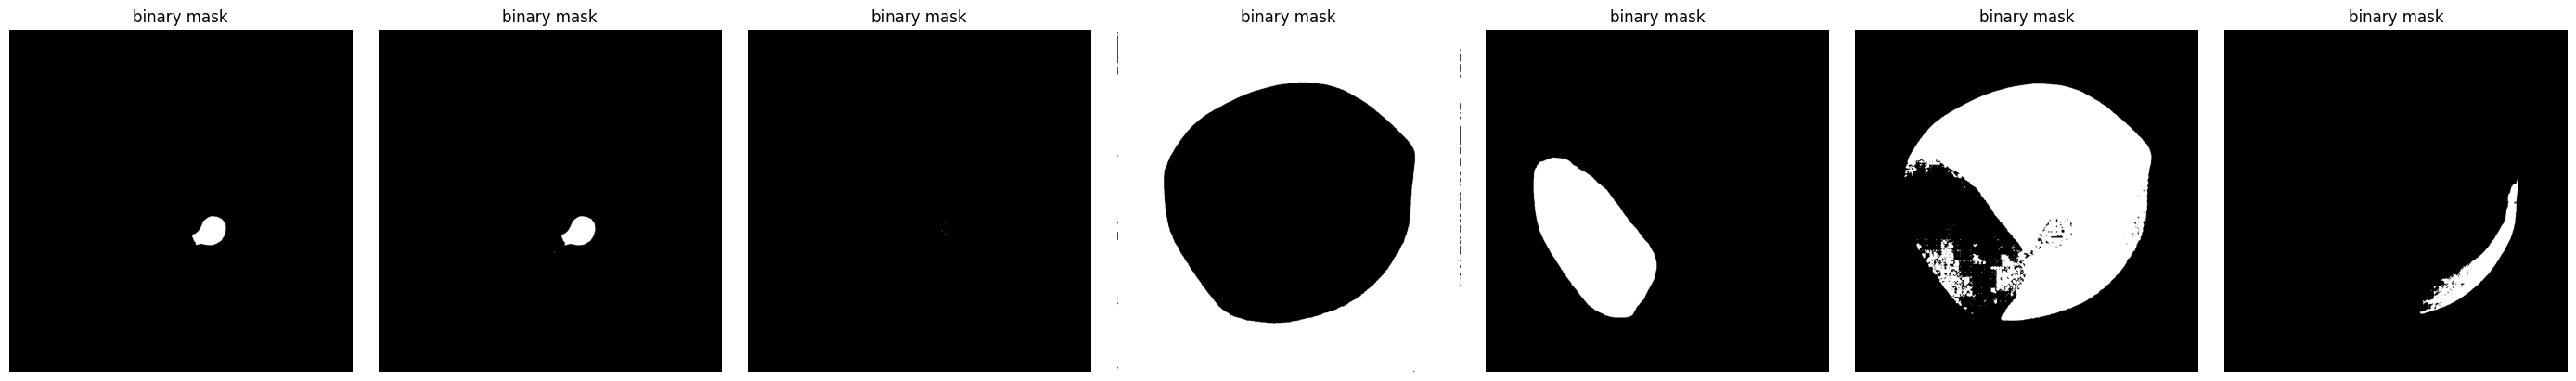

In [5]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
cv2 없이 마스크 정보 확인 & 간단 시각화
"""
import torch, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# ── 파일 경로 ────────────────────────────────────────────
MASK_PT = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/hole/002_siglip_tokens.pt")
IMG_PNG = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/hole/002.png")

# ── 데이터 로드 ─────────────────────────────────────────
data  = torch.load(MASK_PT, map_location="cpu", weights_only=False)
masks = data["mask"]                       # list[np.ndarray]  (H×W) uint8

print(f"마스크 개수: {len(masks)}")
for i, m in enumerate(masks):
    h, w = m.shape
    print(f"  • mask {i:02d}: {h}×{w}  픽셀수={m.sum()}")

# ── (선택) 개별 마스크 흑백 시각화 ───────────────────────
n_show = len(masks)                # 최대 4장까지만 예시
fig, axes = plt.subplots(1, n_show, figsize=(4*n_show, 4))
if n_show == 1:
    axes = [axes]

for ax, seg in zip(axes, masks[:n_show]):
    ax.imshow(seg, cmap="gray")
    ax.set_title("binary mask")
    ax.axis("off")

plt.tight_layout()
plt.show()

## ## Heat Map (SUM)

In [1]:
import torch, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

MASK_PT = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/hole/000_siglip_tokens.pt")
GLOB_PT = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_global/hazelnut/hole/000_global_token.pt")
IMG_PNG = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/hole/000.png")

In [ ]:
MODEL = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
DEV, DTYPE = ("cuda" if torch.cuda.is_available() else "cpu", torch.bfloat16)

proc  = AutoProcessor.from_pretrained(MODEL, trust_remote_code=True)
llava = LlavaOnevisionForConditionalGeneration.from_pretrained(
           MODEL, torch_dtype=DTYPE, device_map="auto",
           low_cpu_mem_usage=True, trust_remote_code=True,
           attn_implementation="eager").eval()
llava.config.pad_token_id = proc.tokenizer.pad_token_id or proc.tokenizer.eos_token_id
TOK_IMG = proc.tokenizer.additional_special_tokens[0]
YES_ID, NO_ID = [proc.tokenizer.encode(w, add_special_tokens=False)[0] for w in ("yes","no")]

d_mask = torch.load(MASK_PT, map_location="cpu", weights_only=False)
g_tok  = torch.load(GLOB_PT, map_location="cpu", weights_only=False)["global_token"]

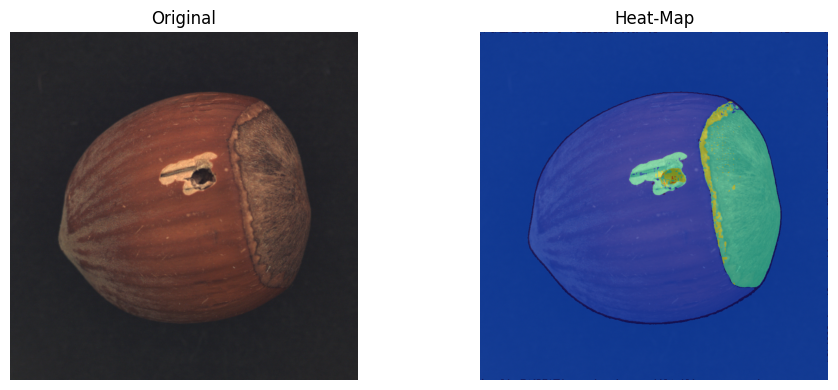

In [4]:
def yes_prob(global_tok, mask_tok):
    vis  = torch.cat([global_tok.unsqueeze(0), mask_tok.unsqueeze(0)], 0)       
    vemb = llava.multi_modal_projector(vis.unsqueeze(0).to(DEV, DTYPE))         

    prompt = f"{TOK_IMG} {TOK_IMG} USER: Is there any anomaly in the image? (Yes / No)\nASSISTANT:"
    tok  = proc.tokenizer(prompt, return_tensors="pt").to(DEV)
    temb = llava.get_input_embeddings()(tok.input_ids).to(DTYPE)

    inp  = torch.cat([vemb, temb], 1)
    amsk = torch.cat([torch.ones(1,2,device=DEV,dtype=torch.long), tok.attention_mask], 1)
    logits = llava(inputs_embeds=inp, attention_mask=amsk, use_cache=False).logits[0,-1]
    return torch.softmax(logits[[YES_ID, NO_ID]], 0)[0].item()       

scores = np.array([yes_prob(g_tok, tok) for tok in d_mask["mask_token"]],
                  dtype=np.float32)                                

heat = np.zeros_like(d_mask["mask"][0], dtype=np.float32)
for s, m in zip(scores, d_mask["mask"]):                            
    heat += float(s) * m                                            

heat -= heat.min()
heat /= heat.max() + 1e-9

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(Image.open(IMG_PNG)); plt.axis('off'); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(Image.open(IMG_PNG));              
plt.imshow(heat, cmap='jet', alpha=0.5);                           
plt.axis('off'); plt.title("Heat-Map")
plt.tight_layout(); plt.show()

## ## Heat Map (Max)

In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

MASK_PT = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/hole/000_siglip_tokens.pt")
GLOB_PT = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_global/hazelnut/hole/000_global_token.pt")
IMG_PNG = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/hole/000.png")

MODEL = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
DEV, DTYPE = ("cuda" if torch.cuda.is_available() else "cpu", torch.bfloat16)

proc  = AutoProcessor.from_pretrained(MODEL, trust_remote_code=True)
llava = LlavaOnevisionForConditionalGeneration.from_pretrained(
           MODEL, torch_dtype=DTYPE, device_map="auto",
           low_cpu_mem_usage=True, trust_remote_code=True,
           attn_implementation="eager").eval()
llava.config.pad_token_id = proc.tokenizer.pad_token_id or proc.tokenizer.eos_token_id
TOK_IMG = proc.tokenizer.additional_special_tokens[0]
YES_ID, NO_ID = [proc.tokenizer.encode(w, add_special_tokens=False)[0] for w in ("yes","no")]

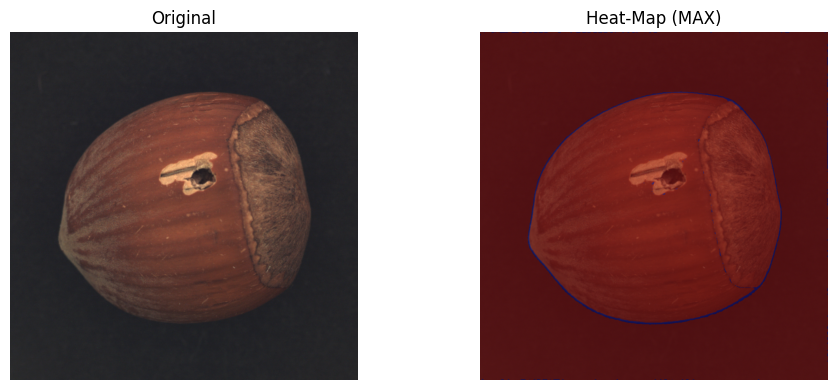

In [3]:
d_mask = torch.load(MASK_PT, map_location="cpu", weights_only=False)
g_tok  = torch.load(GLOB_PT, map_location="cpu", weights_only=False)["global_token"]

def yes_prob(g_tok, m_tok):
    vis  = torch.cat([g_tok.unsqueeze(0), m_tok.unsqueeze(0)], 0)         
    vemb = llava.multi_modal_projector(vis.unsqueeze(0).to(DEV, DTYPE))    
    prompt = f"{TOK_IMG} {TOK_IMG} USER: Is there any anomaly? (Yes / No)\nASSISTANT:"
    tok   = proc.tokenizer(prompt, return_tensors="pt").to(DEV)
    inp   = torch.cat([vemb, llava.get_input_embeddings()(tok.input_ids).to(DTYPE)], 1)
    amsk  = torch.cat([torch.ones(1,2,device=DEV,dtype=torch.long), tok.attention_mask], 1)
    logits = llava(inputs_embeds=inp, attention_mask=amsk, use_cache=False).logits[0,-1]
    return torch.softmax(logits[[YES_ID, NO_ID]], 0)[0].item()            

scores = np.array([yes_prob(g_tok, tok) for tok in d_mask["mask_token"]],
                  dtype=np.float32)                                        

heat = np.zeros_like(d_mask["mask"][0], dtype=np.float32)
for s, m in zip(scores, d_mask["mask"]):
    mask_bool = m.astype(bool)
    heat[mask_bool] = np.maximum(heat[mask_bool], float(s))

heat -= heat.min()
heat /= heat.max() + 1e-9

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(Image.open(IMG_PNG)); plt.axis('off'); plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(Image.open(IMG_PNG));            
plt.imshow(heat, cmap='jet', alpha=0.5)     
plt.axis('off'); plt.title("Heat-Map (MAX)")
plt.tight_layout(); plt.show()

## ## AUROC - Crack

In [ ]:
import torch, numpy as np, pickle
from pathlib import Path
from PIL import Image
from sklearn.metrics import roc_auc_score
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration
from torch.serialization import safe_globals

ROOT_MASK = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/crack")
ROOT_GLOB = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_global/hazelnut/crack")
ROOT_GT   = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/ground_truth/crack")
MODEL     = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
DEV, DTYPE = ("cuda" if torch.cuda.is_available() else "cpu", torch.bfloat16)

proc  = AutoProcessor.from_pretrained(MODEL, trust_remote_code=True)
model = LlavaOnevisionForConditionalGeneration.from_pretrained(
           MODEL, torch_dtype=DTYPE, device_map="auto",
           low_cpu_mem_usage=True, trust_remote_code=True,
           attn_implementation="eager").eval()
model.config.pad_token_id = proc.tokenizer.pad_token_id or proc.tokenizer.eos_token_id
TOK_IMG = proc.tokenizer.additional_special_tokens[0]
YES_ID, NO_ID = [proc.tokenizer.encode(w, add_special_tokens=False)[0] for w in ("yes", "no")]

def load_pt(path):
    return torch.load(path, map_location="cpu", weights_only=False)

In [2]:
def yes_prob(g_tok, m_tok):
    vis  = torch.cat([g_tok.unsqueeze(0), m_tok.unsqueeze(0)], 0)
    vemb = model.multi_modal_projector(vis.unsqueeze(0).to(DEV, DTYPE))
    prompt = f"{TOK_IMG} {TOK_IMG} USER: Is there any anomaly? (Yes / No)\nASSISTANT:"
    tok  = proc.tokenizer(prompt, return_tensors="pt").to(DEV)
    temb = model.get_input_embeddings()(tok.input_ids).to(DTYPE)
    inp  = torch.cat([vemb, temb], 1)
    mask = torch.cat([torch.ones(1,2,device=DEV,dtype=torch.long), tok.attention_mask], 1)
    with torch.no_grad():
        logits = model(inputs_embeds=inp, attention_mask=mask, use_cache=False).logits[0,-1]
    return torch.softmax(logits[[YES_ID, NO_ID]], 0)[0].item()

def make_heatmap(w, masks):
    heat = np.zeros_like(masks[0], dtype=np.float32)
    for wi, mi in zip(w, masks):
        heat += float(wi) * mi
    return heat.ravel()

all_pred, all_gt = [], []
for idx in range(18):
    f_mask = ROOT_MASK / f"{idx:03d}_siglip_tokens.pt"
    f_glo  = ROOT_GLOB / f"{idx:03d}_global_token.pt"
    f_gt   = ROOT_GT   / f"{idx:03d}_mask.png"
    if not (f_mask.exists() and f_glo.exists() and f_gt.exists()):
        print(f"[{idx:03d}]  ⨯ file missing"); continue

    d = load_pt(f_mask)
    g = load_pt(f_glo)["global_token"]
    p = [yes_prob(g, tok) for tok in d["mask_token"]]          
    w = np.array(p, dtype=np.float32)                          

    heat = make_heatmap(w, d["mask"])
    gt   = (np.array(Image.open(f_gt).convert("L")) > 0).astype(np.uint8).ravel()
    auc  = roc_auc_score(gt, heat)
    print(f"[{idx:03d}]  Pixel-AUROC = {auc:.4f}")

    all_pred.append(heat); all_gt.append(gt)

auc_total = roc_auc_score(np.concatenate(all_gt), np.concatenate(all_pred))
print(f"\n► hazelnut / crack  TOTAL Pixel-AUROC : {auc_total:.4f}")

[000]  Pixel-AUROC = 0.7612
[001]  Pixel-AUROC = 0.8837
[002]  Pixel-AUROC = 0.6246
[003]  Pixel-AUROC = 0.7801
[004]  Pixel-AUROC = 0.9196
[005]  Pixel-AUROC = 0.7915
[006]  Pixel-AUROC = 0.5904
[007]  Pixel-AUROC = 0.8085
[008]  Pixel-AUROC = 0.7956
[009]  Pixel-AUROC = 0.8781
[010]  Pixel-AUROC = 0.4062
[011]  Pixel-AUROC = 0.9230
[012]  Pixel-AUROC = 0.7988
[013]  Pixel-AUROC = 0.7924
[014]  Pixel-AUROC = 0.8210
[015]  Pixel-AUROC = 0.8407
[016]  Pixel-AUROC = 0.8204
[017]  Pixel-AUROC = 0.8900

► hazelnut / crack  TOTAL Pixel-AUROC : 0.6279


## ## AUROC - Cut

In [ ]:
import torch, numpy as np, pickle
from pathlib import Path
from PIL import Image
from sklearn.metrics import roc_auc_score
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration
from torch.serialization import safe_globals

ROOT_MASK = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/cut")
ROOT_GLOB = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_global/hazelnut/cut")
ROOT_GT   = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/ground_truth/cut")
MODEL     = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
DEV, DTYPE = ("cuda" if torch.cuda.is_available() else "cpu", torch.bfloat16)

proc  = AutoProcessor.from_pretrained(MODEL, trust_remote_code=True)
model = LlavaOnevisionForConditionalGeneration.from_pretrained(
           MODEL, torch_dtype=DTYPE, device_map="auto",
           low_cpu_mem_usage=True, trust_remote_code=True,
           attn_implementation="eager").eval()
model.config.pad_token_id = proc.tokenizer.pad_token_id or proc.tokenizer.eos_token_id
TOK_IMG = proc.tokenizer.additional_special_tokens[0]
YES_ID, NO_ID = [proc.tokenizer.encode(w, add_special_tokens=False)[0] for w in ("yes", "no")]

def load_pt(path):
    return torch.load(path, map_location="cpu", weights_only=False)

In [3]:
def yes_prob(g_tok, m_tok):
    vis  = torch.cat([g_tok.unsqueeze(0), m_tok.unsqueeze(0)], 0)
    vemb = model.multi_modal_projector(vis.unsqueeze(0).to(DEV, DTYPE))
    prompt = f"{TOK_IMG} {TOK_IMG} USER: Is there any anomaly? (Yes / No)\nASSISTANT:"
    tok  = proc.tokenizer(prompt, return_tensors="pt").to(DEV)
    temb = model.get_input_embeddings()(tok.input_ids).to(DTYPE)
    inp  = torch.cat([vemb, temb], 1)
    mask = torch.cat([torch.ones(1,2,device=DEV,dtype=torch.long), tok.attention_mask], 1)
    with torch.no_grad():
        logits = model(inputs_embeds=inp, attention_mask=mask, use_cache=False).logits[0,-1]
    return torch.softmax(logits[[YES_ID, NO_ID]], 0)[0].item()

def make_heatmap(w, masks):
    heat = np.zeros_like(masks[0], dtype=np.float32)
    for wi, mi in zip(w, masks):
        heat += float(wi) * mi
    return heat.ravel()

all_pred, all_gt = [], []
for idx in range(17):
    f_mask = ROOT_MASK / f"{idx:03d}_siglip_tokens.pt"
    f_glo  = ROOT_GLOB / f"{idx:03d}_global_token.pt"
    f_gt   = ROOT_GT   / f"{idx:03d}_mask.png"
    if not (f_mask.exists() and f_glo.exists() and f_gt.exists()):
        print(f"[{idx:03d}]  ⨯ file missing"); continue

    d = load_pt(f_mask)
    g = load_pt(f_glo)["global_token"]
    p = [yes_prob(g, tok) for tok in d["mask_token"]]        
    w = np.array(p, dtype=np.float32)                        

    heat = make_heatmap(w, d["mask"])
    gt   = (np.array(Image.open(f_gt).convert("L")) > 0).astype(np.uint8).ravel()
    auc  = roc_auc_score(gt, heat)
    print(f"[{idx:03d}]  Pixel-AUROC = {auc:.4f}")

    all_pred.append(heat); all_gt.append(gt)

auc_total = roc_auc_score(np.concatenate(all_gt), np.concatenate(all_pred))
print(f"\n► hazelnut / cut  TOTAL Pixel-AUROC : {auc_total:.4f}")

[000]  Pixel-AUROC = 0.9280
[001]  Pixel-AUROC = 0.4837
[002]  Pixel-AUROC = 0.8604
[003]  Pixel-AUROC = 0.7724
[004]  Pixel-AUROC = 0.7757
[005]  Pixel-AUROC = 0.9075
[006]  Pixel-AUROC = 0.7620
[007]  Pixel-AUROC = 0.9740
[008]  Pixel-AUROC = 0.8052
[009]  Pixel-AUROC = 0.9333
[010]  Pixel-AUROC = 0.7952
[011]  Pixel-AUROC = 0.7398
[012]  Pixel-AUROC = 0.9561
[013]  Pixel-AUROC = 0.6849
[014]  Pixel-AUROC = 0.9397
[015]  Pixel-AUROC = 0.8094
[016]  Pixel-AUROC = 0.7433

► hazelnut / cut  TOTAL Pixel-AUROC : 0.8071


## ## AUROC - Hole

In [ ]:
import torch, numpy as np, pickle
from pathlib import Path
from PIL import Image
from sklearn.metrics import roc_auc_score
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration
from torch.serialization import safe_globals

ROOT_MASK = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/hole")
ROOT_GLOB = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_global/hazelnut/hole")
ROOT_GT   = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/ground_truth/hole")
MODEL     = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
DEV, DTYPE = ("cuda" if torch.cuda.is_available() else "cpu", torch.bfloat16)

proc  = AutoProcessor.from_pretrained(MODEL, trust_remote_code=True)
model = LlavaOnevisionForConditionalGeneration.from_pretrained(
           MODEL, torch_dtype=DTYPE, device_map="auto",
           low_cpu_mem_usage=True, trust_remote_code=True,
           attn_implementation="eager").eval()
model.config.pad_token_id = proc.tokenizer.pad_token_id or proc.tokenizer.eos_token_id
TOK_IMG = proc.tokenizer.additional_special_tokens[0]
YES_ID, NO_ID = [proc.tokenizer.encode(w, add_special_tokens=False)[0] for w in ("yes", "no")]

def load_pt(path):
    return torch.load(path, map_location="cpu", weights_only=False)

In [3]:
def yes_prob(g_tok, m_tok):
    vis  = torch.cat([g_tok.unsqueeze(0), m_tok.unsqueeze(0)], 0)
    vemb = model.multi_modal_projector(vis.unsqueeze(0).to(DEV, DTYPE))
    prompt = f"{TOK_IMG} {TOK_IMG} USER: Is there any anomaly? (Yes / No)\nASSISTANT:"
    tok  = proc.tokenizer(prompt, return_tensors="pt").to(DEV)
    temb = model.get_input_embeddings()(tok.input_ids).to(DTYPE)
    inp  = torch.cat([vemb, temb], 1)
    mask = torch.cat([torch.ones(1,2,device=DEV,dtype=torch.long), tok.attention_mask], 1)
    with torch.no_grad():
        logits = model(inputs_embeds=inp, attention_mask=mask, use_cache=False).logits[0,-1]
    return torch.softmax(logits[[YES_ID, NO_ID]], 0)[0].item()

def make_heatmap(w, masks):
    heat = np.zeros_like(masks[0], dtype=np.float32)
    for wi, mi in zip(w, masks):
        heat += float(wi) * mi
    return heat.ravel()

all_pred, all_gt = [], []
for idx in range(18):
    f_mask = ROOT_MASK / f"{idx:03d}_siglip_tokens.pt"
    f_glo  = ROOT_GLOB / f"{idx:03d}_global_token.pt"
    f_gt   = ROOT_GT   / f"{idx:03d}_mask.png"
    if not (f_mask.exists() and f_glo.exists() and f_gt.exists()):
        print(f"[{idx:03d}]  ⨯ file missing"); continue

    d = load_pt(f_mask)
    g = load_pt(f_glo)["global_token"]
    p = [yes_prob(g, tok) for tok in d["mask_token"]]         
    w = np.array(p, dtype=np.float32)                         

    heat = make_heatmap(w, d["mask"])
    gt   = (np.array(Image.open(f_gt).convert("L")) > 0).astype(np.uint8).ravel()
    auc  = roc_auc_score(gt, heat)
    print(f"[{idx:03d}]  Pixel-AUROC = {auc:.4f}")

    all_pred.append(heat); all_gt.append(gt)

auc_total = roc_auc_score(np.concatenate(all_gt), np.concatenate(all_pred))
print(f"\n► hazelnut / hole  TOTAL Pixel-AUROC : {auc_total:.4f}")

[000]  Pixel-AUROC = 0.8604
[001]  Pixel-AUROC = 0.7607
[002]  Pixel-AUROC = 0.8637
[003]  Pixel-AUROC = 0.9618
[004]  Pixel-AUROC = 0.9187
[005]  Pixel-AUROC = 0.9350
[006]  Pixel-AUROC = 0.7147
[007]  Pixel-AUROC = 0.2237
[008]  Pixel-AUROC = 0.7332
[009]  Pixel-AUROC = 0.8037
[010]  Pixel-AUROC = 0.7753
[011]  Pixel-AUROC = 0.8174
[012]  Pixel-AUROC = 0.8805
[013]  Pixel-AUROC = 0.9367
[014]  Pixel-AUROC = 0.9309
[015]  Pixel-AUROC = 0.5226
[016]  Pixel-AUROC = 0.7051
[017]  Pixel-AUROC = 0.8869

► hazelnut / hole  TOTAL Pixel-AUROC : 0.8199


## ## AUROC - Print

In [ ]:
import torch, numpy as np, pickle
from pathlib import Path
from PIL import Image
from sklearn.metrics import roc_auc_score
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration
from torch.serialization import safe_globals

ROOT_MASK = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/print")
ROOT_GLOB = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_global/hazelnut/print")
ROOT_GT   = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/ground_truth/print")
MODEL     = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
DEV, DTYPE = ("cuda" if torch.cuda.is_available() else "cpu", torch.bfloat16)

proc  = AutoProcessor.from_pretrained(MODEL, trust_remote_code=True)
model = LlavaOnevisionForConditionalGeneration.from_pretrained(
           MODEL, torch_dtype=DTYPE, device_map="auto",
           low_cpu_mem_usage=True, trust_remote_code=True,
           attn_implementation="eager").eval()
model.config.pad_token_id = proc.tokenizer.pad_token_id or proc.tokenizer.eos_token_id
TOK_IMG = proc.tokenizer.additional_special_tokens[0]
YES_ID, NO_ID = [proc.tokenizer.encode(w, add_special_tokens=False)[0] for w in ("yes", "no")]

def load_pt(path):
    return torch.load(path, map_location="cpu", weights_only=False)

In [3]:
def yes_prob(g_tok, m_tok):
    vis  = torch.cat([g_tok.unsqueeze(0), m_tok.unsqueeze(0)], 0)
    vemb = model.multi_modal_projector(vis.unsqueeze(0).to(DEV, DTYPE))
    prompt = f"{TOK_IMG} {TOK_IMG} USER: Is there any anomaly? (Yes / No)\nASSISTANT:"
    tok  = proc.tokenizer(prompt, return_tensors="pt").to(DEV)
    temb = model.get_input_embeddings()(tok.input_ids).to(DTYPE)
    inp  = torch.cat([vemb, temb], 1)
    mask = torch.cat([torch.ones(1,2,device=DEV,dtype=torch.long), tok.attention_mask], 1)
    with torch.no_grad():
        logits = model(inputs_embeds=inp, attention_mask=mask, use_cache=False).logits[0,-1]
    return torch.softmax(logits[[YES_ID, NO_ID]], 0)[0].item()

def make_heatmap(w, masks):
    heat = np.zeros_like(masks[0], dtype=np.float32)
    for wi, mi in zip(w, masks):
        heat += float(wi) * mi
    return heat.ravel()

all_pred, all_gt = [], []
for idx in range(17):
    f_mask = ROOT_MASK / f"{idx:03d}_siglip_tokens.pt"
    f_glo  = ROOT_GLOB / f"{idx:03d}_global_token.pt"
    f_gt   = ROOT_GT   / f"{idx:03d}_mask.png"
    if not (f_mask.exists() and f_glo.exists() and f_gt.exists()):
        print(f"[{idx:03d}]  ⨯ file missing"); continue

    d = load_pt(f_mask)
    g = load_pt(f_glo)["global_token"]
    p = [yes_prob(g, tok) for tok in d["mask_token"]]        
    w = np.array(p, dtype=np.float32)                         

    heat = make_heatmap(w, d["mask"])
    gt   = (np.array(Image.open(f_gt).convert("L")) > 0).astype(np.uint8).ravel()
    auc  = roc_auc_score(gt, heat)
    print(f"[{idx:03d}]  Pixel-AUROC = {auc:.4f}")

    all_pred.append(heat); all_gt.append(gt)

auc_total = roc_auc_score(np.concatenate(all_gt), np.concatenate(all_pred))
print(f"\n► hazelnut / print  TOTAL Pixel-AUROC : {auc_total:.4f}")

[000]  Pixel-AUROC = 0.9633
[001]  Pixel-AUROC = 0.9371
[002]  Pixel-AUROC = 0.7028
[003]  Pixel-AUROC = 0.6675
[004]  Pixel-AUROC = 0.5647
[005]  Pixel-AUROC = 0.7292
[006]  Pixel-AUROC = 0.8704
[007]  Pixel-AUROC = 0.8907
[008]  Pixel-AUROC = 0.8432
[009]  Pixel-AUROC = 0.9464
[010]  Pixel-AUROC = 0.7694
[011]  Pixel-AUROC = 0.8665
[012]  Pixel-AUROC = 0.8144
[013]  Pixel-AUROC = 0.2423
[014]  Pixel-AUROC = 0.7941
[015]  Pixel-AUROC = 0.7606
[016]  Pixel-AUROC = 0.8688

► hazelnut / print  TOTAL Pixel-AUROC : 0.7883


# # Anomaly Scoring = Attention

## ## 000.png

In [2]:
import torch
from pathlib import Path
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

MASK_PT = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/hole/000_siglip_tokens.pt")
MODEL = "llava-hf/llava-onevision-qwen2-7b-ov-hf"

DEV, DTYPE = ("cuda" if torch.cuda.is_available() else "cpu", torch.bfloat16)

In [ ]:
proc = AutoProcessor.from_pretrained(MODEL, trust_remote_code=True)
llava = LlavaOnevisionForConditionalGeneration.from_pretrained(
    MODEL,
    torch_dtype=DTYPE,
    device_map="auto",
    low_cpu_mem_usage=True,
    trust_remote_code=True,
).eval()
TOK_IMG = proc.tokenizer.additional_special_tokens[0]

In [4]:
data = torch.load(MASK_PT, map_location="cpu", weights_only=False)
mask_tok = data["mask_token"] 
M = mask_tok.size(0)
v_emb = llava.multi_modal_projector(mask_tok.unsqueeze(0).to(DEV, DTYPE)) 

prompt = (
    (TOK_IMG + " ") * M
    + "USER: Is there any anomaly in the image? (Yes / No)\nASSISTANT:"
)
tok_in = proc.tokenizer(prompt, return_tensors="pt").to(DEV)
t_emb = llava.get_input_embeddings()(tok_in.input_ids).to(DTYPE)

out = llava.generate(
    inputs_embeds=torch.cat([v_emb, t_emb], 1),
    attention_mask=torch.cat(
        [torch.ones(1, M, device=DEV, dtype=torch.long), tok_in.attention_mask], 1
    ),
    max_new_tokens=1,
    return_dict_in_generate=True,
    output_attentions=True,
    do_sample=False,
)
gen_word = proc.tokenizer.decode([out.sequences[0, -1].item()]).strip()
print(f"\nLLaVA generated first word: **{gen_word}**")

att = out.attentions[-1][0][0]  
att_to_mask = att[:, -1, :M]  
assert att_to_mask.shape == (att.size(0), M), "Vision slice mismatch"

score_mean = torch.softmax(att_to_mask.mean(0), dim=0)         
score_max = torch.softmax(att_to_mask.max(0).values, dim=0)   

def show_top(tag, tensor, k=3):
    vals, idxs = torch.topk(tensor, k)
    print(f"\n[{tag}] top-{k}")
    for i in range(k):
        print(f"  mask {int(idxs[i]):02d}   score={float(vals[i]):.4f}")

show_top("Head MEAN", score_mean)
show_top("Head MAX", score_max)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.



LLaVA generated first word: **No**

[Head MEAN] top-3
  mask 02   score=0.1250
  mask 01   score=0.1250
  mask 00   score=0.1250

[Head MAX] top-3
  mask 04   score=0.1270
  mask 02   score=0.1260
  mask 00   score=0.1245


# # Head Mean/Max AUROC (Anomaly Scoring = Attention)

## ## 000.png

In [1]:
import torch, numpy as np
from pathlib import Path
from PIL import Image
from sklearn.metrics import roc_auc_score
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

MASK_PT = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/hole/000_siglip_tokens.pt")
GT_PNG  = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/ground_truth/hole/000_mask.png")  
MODEL   = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
DEV, DTYPE = ("cuda" if torch.cuda.is_available() else "cpu", torch.bfloat16)

In [ ]:
proc  = AutoProcessor.from_pretrained(MODEL, trust_remote_code=True)
llava = LlavaOnevisionForConditionalGeneration.from_pretrained(
           MODEL, torch_dtype=DTYPE, device_map="auto",
           low_cpu_mem_usage=True, trust_remote_code=True).eval()
TOK_IMG = proc.tokenizer.additional_special_tokens[0]

In [3]:
data      = torch.load(MASK_PT, map_location="cpu", weights_only=False)
mask_tok  = data["mask_token"]         
masks_bin = data["mask"]               
M = mask_tok.size(0)
v_emb = llava.multi_modal_projector(mask_tok.unsqueeze(0).to(DEV, DTYPE))

prompt = f"{(TOK_IMG+' ')*M}USER: Is there any anomaly in the image? (Yes / No)\nASSISTANT:"
tok_in = proc.tokenizer(prompt, return_tensors="pt").to(DEV)
t_emb  = llava.get_input_embeddings()(tok_in.input_ids).to(DTYPE)

out = llava.generate(
        inputs_embeds   = torch.cat([v_emb, t_emb], 1),
        attention_mask  = torch.cat([torch.ones(1, M, device=DEV, dtype=torch.long),
                                     tok_in.attention_mask], 1),
        max_new_tokens  = 1,
        return_dict_in_generate=True,
        output_attentions=True,
        do_sample=False)

print("First generated word :", proc.tokenizer.decode(out.sequences[0,-1].item()))

att_last = out.attentions[-1][0][0]     
att_mask = att_last[:, -1, :M]           
assert att_mask.shape[1] == M

score_mean = torch.softmax(att_mask.mean(0), dim=0).cpu()     
score_max  = torch.softmax(att_mask.max(0).values, dim=0).cpu()

def make_heatmap(scores, masks):
    heat = np.zeros_like(masks[0], dtype=np.float32)
    for s, m in zip(scores, masks):
        heat += float(s) * m     
    heat -= heat.min()           
    return heat.ravel()

gt_arr = (np.array(Image.open(GT_PNG).convert("L")) > 0).astype(np.uint8).ravel()

auroc_mean = roc_auc_score(gt_arr, make_heatmap(score_mean, masks_bin))
auroc_max  = roc_auc_score(gt_arr, make_heatmap(score_max,  masks_bin))

print(f"\nPixel-AUROC  (Head-MEAN) : {auroc_mean:.4f}")
print(f"Pixel-AUROC  (Head-MAX ) : {auroc_max :.4f}")

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


First generated word :  No

Pixel-AUROC  (Head-MEAN) : 0.9008
Pixel-AUROC  (Head-MAX ) : 0.8667


## ## Heat Map (SUM)

In [1]:
import torch, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

MASK_PT = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/hole/000_siglip_tokens.pt")
IMG_PNG = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/hole/000.png")

In [ ]:
MODEL = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
DEV, DTYPE = ("cuda" if torch.cuda.is_available() else "cpu", torch.bfloat16)

proc  = AutoProcessor.from_pretrained(MODEL, trust_remote_code=True)
llava = LlavaOnevisionForConditionalGeneration.from_pretrained(
           MODEL, torch_dtype=DTYPE, device_map="auto",
           low_cpu_mem_usage=True, trust_remote_code=True,
           attn_implementation="eager").eval()
llava.config.pad_token_id = proc.tokenizer.pad_token_id or proc.tokenizer.eos_token_id
TOK_IMG = proc.tokenizer.additional_special_tokens[0]

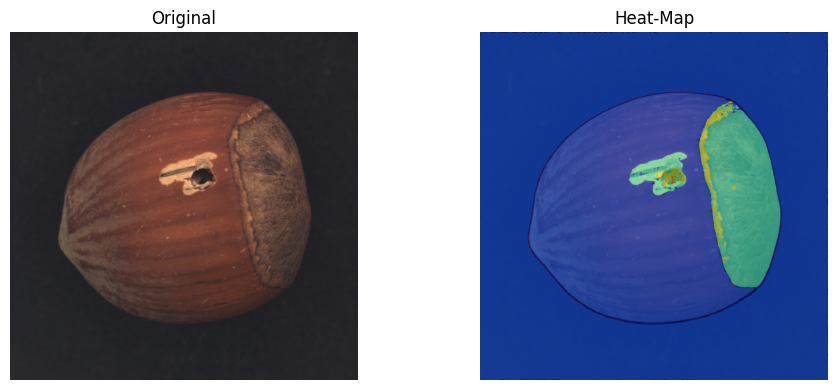

In [4]:
def attention_score(mask_tok):
    M = mask_tok.size(0)
    v = llava.multi_modal_projector(mask_tok.unsqueeze(0).to(DEV, DTYPE))

    prompt = f"{(TOK_IMG+' ')*M}USER: Is there any anomaly in the image? (Yes / No)\nASSISTANT:"
    tok  = proc.tokenizer(prompt, return_tensors="pt").to(DEV)
    temb = llava.get_input_embeddings()(tok.input_ids).to(DTYPE)

    out = llava.generate(
            inputs_embeds   = torch.cat([v, temb], 1),
            attention_mask  = torch.cat([torch.ones(1, M, device=DEV, dtype=torch.long),
                                         tok.attention_mask], 1),
            max_new_tokens  = 1,
            return_dict_in_generate=True,
            output_attentions=True,
            do_sample=False,
            pad_token_id=llava.config.pad_token_id)

    att = out.attentions[-1][0][0]         
    α   = att[:, -1, :M].mean(0).float()    
    return torch.softmax(α, dim=0).cpu().numpy() 

data   = torch.load(MASK_PT, map_location="cpu", weights_only=False)
scores = attention_score(data["mask_token"])         
masks  = data["mask"]                                

heat = np.zeros_like(masks[0], dtype=np.float32)
for s, m in zip(scores, masks):
    heat += float(s) * m                              

heat -= heat.min()
heat /= heat.max() + 1e-9

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(Image.open(IMG_PNG)); plt.axis('off'); plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(Image.open(IMG_PNG))
plt.imshow(heat, cmap='jet', alpha=0.5)     
plt.axis('off'); plt.title("Heat-Map")
plt.tight_layout(); plt.show()

## ## Crack

In [2]:
import torch, numpy as np
from pathlib import Path
from PIL import Image
from sklearn.metrics import roc_auc_score
from transformers import (
    AutoProcessor,
    LlavaOnevisionForConditionalGeneration,
)

ROOT_MASK = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/crack")
ROOT_GT   = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/ground_truth/crack")
MODEL     = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
DEV, DTYPE = ("cuda" if torch.cuda.is_available() else "cpu", torch.bfloat16)

In [ ]:
proc  = AutoProcessor.from_pretrained(MODEL, trust_remote_code=True)
llava = LlavaOnevisionForConditionalGeneration.from_pretrained(
           MODEL,
           torch_dtype=DTYPE,
           device_map="auto",
           low_cpu_mem_usage=True,
           trust_remote_code=True,
           attn_implementation="eager",          
       ).eval()

In [5]:
llava.config.pad_token_id = proc.tokenizer.pad_token_id or proc.tokenizer.eos_token_id
TOK_IMG = proc.tokenizer.additional_special_tokens[0]

def get_score_mean(mask_tok):
    M   = mask_tok.size(0)
    v   = llava.multi_modal_projector(mask_tok.unsqueeze(0).to(DEV, DTYPE))

    prompt = f"{(TOK_IMG+' ')*M}USER: Is there any anomaly in the image? (Yes / No)\nASSISTANT:"
    tok   = proc.tokenizer(prompt, return_tensors="pt").to(DEV)
    t_emb = llava.get_input_embeddings()(tok.input_ids).to(DTYPE)

    out = llava.generate(
            inputs_embeds   = torch.cat([v, t_emb], 1),
            attention_mask  = torch.cat(
                                [torch.ones(1, M, device=DEV, dtype=torch.long), tok.attention_mask],
                                1),
            max_new_tokens  = 1,
            return_dict_in_generate=True,
            output_attentions=True,
            do_sample=False,
            pad_token_id=llava.config.pad_token_id            
        )

    att = out.attentions[-1][0][0]       
    α   = att[:, -1, :M]                  
    return torch.softmax(α.mean(0), dim=0).cpu()   

def make_heatmap(scores, masks):
    heat = np.zeros_like(masks[0], dtype=np.float32)
    for s, m in zip(scores, masks):
        heat += float(s) * m               
    return heat.ravel()

per_img_auc, all_pred, all_gt = {}, [], []
for idx in range(18):
    pt_file = ROOT_MASK / f"{idx:03d}_siglip_tokens.pt"
    gt_png  = ROOT_GT   / f"{idx:03d}_mask.png"
    if not (pt_file.exists() and gt_png.exists()):
        print(f"[{idx:03d}]  ⨯ file missing"); continue

    data  = torch.load(pt_file, map_location="cpu", weights_only=False)
    score = get_score_mean(data["mask_token"])       
    heat  = make_heatmap(score, data["mask"])
    gt    = (np.array(Image.open(gt_png).convert("L")) > 0).astype(np.uint8).ravel()

    auc   = roc_auc_score(gt, heat)
    per_img_auc[f"{idx:03d}"] = auc
    all_pred.append(heat)
    all_gt  .append(gt)
    print(f"[{idx:03d}]  Pixel-AUROC = {auc:.4f}")

auc_total = roc_auc_score(np.concatenate(all_gt), np.concatenate(all_pred))
print(f"\n► hazelnut / crack  TOTAL Pixel-AUROC : {auc_total:.4f}")

[000]  Pixel-AUROC = 0.7796
[001]  Pixel-AUROC = 0.9294
[002]  Pixel-AUROC = 0.5957
[003]  Pixel-AUROC = 0.8640
[004]  Pixel-AUROC = 0.8995
[005]  Pixel-AUROC = 0.7368
[006]  Pixel-AUROC = 0.7294
[007]  Pixel-AUROC = 0.5054
[008]  Pixel-AUROC = 0.5880
[009]  Pixel-AUROC = 0.5780
[010]  Pixel-AUROC = 0.4511
[011]  Pixel-AUROC = 0.8252
[012]  Pixel-AUROC = 0.8613
[013]  Pixel-AUROC = 0.8026
[014]  Pixel-AUROC = 0.8607
[015]  Pixel-AUROC = 0.7493
[016]  Pixel-AUROC = 0.7924
[017]  Pixel-AUROC = 0.5127

► hazelnut / crack  TOTAL Pixel-AUROC : 0.5405


## ## Cut

In [1]:
import torch, numpy as np
from pathlib import Path
from PIL import Image
from sklearn.metrics import roc_auc_score
from transformers import (
    AutoProcessor,
    LlavaOnevisionForConditionalGeneration,
)

ROOT_MASK = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/cut")
ROOT_GT   = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/ground_truth/cut")
MODEL     = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
DEV, DTYPE = ("cuda" if torch.cuda.is_available() else "cpu", torch.bfloat16)

In [ ]:
proc  = AutoProcessor.from_pretrained(MODEL, trust_remote_code=True)
llava = LlavaOnevisionForConditionalGeneration.from_pretrained(
           MODEL,
           torch_dtype=DTYPE,
           device_map="auto",
           low_cpu_mem_usage=True,
           trust_remote_code=True,
           attn_implementation="eager",         
       ).eval()

In [4]:
llava.config.pad_token_id = proc.tokenizer.pad_token_id or proc.tokenizer.eos_token_id
TOK_IMG = proc.tokenizer.additional_special_tokens[0]

def get_score_mean(mask_tok):
    M   = mask_tok.size(0)
    v   = llava.multi_modal_projector(mask_tok.unsqueeze(0).to(DEV, DTYPE))

    prompt = f"{(TOK_IMG+' ')*M}USER: Is there any anomaly in the image? (Yes / No)\nASSISTANT:"
    tok   = proc.tokenizer(prompt, return_tensors="pt").to(DEV)
    t_emb = llava.get_input_embeddings()(tok.input_ids).to(DTYPE)

    out = llava.generate(
            inputs_embeds   = torch.cat([v, t_emb], 1),
            attention_mask  = torch.cat(
                                [torch.ones(1, M, device=DEV, dtype=torch.long), tok.attention_mask],
                                1),
            max_new_tokens  = 1,
            return_dict_in_generate=True,
            output_attentions=True,
            do_sample=False,
            pad_token_id=llava.config.pad_token_id       
        )

    att = out.attentions[-1][0][0]       
    α   = att[:, -1, :M]                 
    return torch.softmax(α.mean(0), dim=0).cpu()  

def make_heatmap(scores, masks):
    heat = np.zeros_like(masks[0], dtype=np.float32)
    for s, m in zip(scores, masks):
        heat += float(s) * m             
    return heat.ravel()

per_img_auc, all_pred, all_gt = {}, [], []
for idx in range(17):
    pt_file = ROOT_MASK / f"{idx:03d}_siglip_tokens.pt"
    gt_png  = ROOT_GT   / f"{idx:03d}_mask.png"
    if not (pt_file.exists() and gt_png.exists()):
        print(f"[{idx:03d}]  ⨯ file missing"); continue

    data  = torch.load(pt_file, map_location="cpu", weights_only=False)
    score = get_score_mean(data["mask_token"])        
    heat  = make_heatmap(score, data["mask"])
    gt    = (np.array(Image.open(gt_png).convert("L")) > 0).astype(np.uint8).ravel()

    auc   = roc_auc_score(gt, heat)
    per_img_auc[f"{idx:03d}"] = auc
    all_pred.append(heat)
    all_gt  .append(gt)
    print(f"[{idx:03d}]  Pixel-AUROC = {auc:.4f}")

auc_total = roc_auc_score(np.concatenate(all_gt), np.concatenate(all_pred))
print(f"\n► hazelnut / cut  TOTAL Pixel-AUROC : {auc_total:.4f}")

[000]  Pixel-AUROC = 0.9280
[001]  Pixel-AUROC = 0.6535
[002]  Pixel-AUROC = 0.8840
[003]  Pixel-AUROC = 0.8675
[004]  Pixel-AUROC = 0.8346
[005]  Pixel-AUROC = 0.9017
[006]  Pixel-AUROC = 0.8284
[007]  Pixel-AUROC = 0.9390
[008]  Pixel-AUROC = 0.8648
[009]  Pixel-AUROC = 0.8319
[010]  Pixel-AUROC = 0.8522
[011]  Pixel-AUROC = 0.8169
[012]  Pixel-AUROC = 0.8592
[013]  Pixel-AUROC = 0.7890
[014]  Pixel-AUROC = 0.8744
[015]  Pixel-AUROC = 0.8099
[016]  Pixel-AUROC = 0.8451

► hazelnut / cut  TOTAL Pixel-AUROC : 0.7979


## ## Hole

In [1]:
import torch, numpy as np
from pathlib import Path
from PIL import Image
from sklearn.metrics import roc_auc_score
from transformers import (
    AutoProcessor,
    LlavaOnevisionForConditionalGeneration,
)

ROOT_MASK = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/hole")
ROOT_GT   = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/ground_truth/hole")
MODEL     = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
DEV, DTYPE = ("cuda" if torch.cuda.is_available() else "cpu", torch.bfloat16)

In [ ]:
proc  = AutoProcessor.from_pretrained(MODEL, trust_remote_code=True)
llava = LlavaOnevisionForConditionalGeneration.from_pretrained(
           MODEL,
           torch_dtype=DTYPE,
           device_map="auto",
           low_cpu_mem_usage=True,
           trust_remote_code=True,
           attn_implementation="eager",          
       ).eval()

In [3]:
llava.config.pad_token_id = proc.tokenizer.pad_token_id or proc.tokenizer.eos_token_id
TOK_IMG = proc.tokenizer.additional_special_tokens[0]

def get_score_mean(mask_tok):
    M   = mask_tok.size(0)
    v   = llava.multi_modal_projector(mask_tok.unsqueeze(0).to(DEV, DTYPE))

    prompt = f"{(TOK_IMG+' ')*M}USER: Is there any anomaly in the image? (Yes / No)\nASSISTANT:"
    tok   = proc.tokenizer(prompt, return_tensors="pt").to(DEV)
    t_emb = llava.get_input_embeddings()(tok.input_ids).to(DTYPE)

    out = llava.generate(
            inputs_embeds   = torch.cat([v, t_emb], 1),
            attention_mask  = torch.cat(
                                [torch.ones(1, M, device=DEV, dtype=torch.long), tok.attention_mask],
                                1),
            max_new_tokens  = 1,
            return_dict_in_generate=True,
            output_attentions=True,
            do_sample=False,
            pad_token_id=llava.config.pad_token_id            
        )

    att = out.attentions[-1][0][0]       
    α   = att[:, -1, :M]                  
    return torch.softmax(α.mean(0), dim=0).cpu()  

def make_heatmap(scores, masks):
    heat = np.zeros_like(masks[0], dtype=np.float32)
    for s, m in zip(scores, masks):
        heat += float(s) * m               
    return heat.ravel()

per_img_auc, all_pred, all_gt = {}, [], []
for idx in range(18):
    pt_file = ROOT_MASK / f"{idx:03d}_siglip_tokens.pt"
    gt_png  = ROOT_GT   / f"{idx:03d}_mask.png"
    if not (pt_file.exists() and gt_png.exists()):
        print(f"[{idx:03d}]  ⨯ file missing"); continue

    data  = torch.load(pt_file, map_location="cpu", weights_only=False)
    score = get_score_mean(data["mask_token"])         
    heat  = make_heatmap(score, data["mask"])
    gt    = (np.array(Image.open(gt_png).convert("L")) > 0).astype(np.uint8).ravel()

    auc   = roc_auc_score(gt, heat)
    per_img_auc[f"{idx:03d}"] = auc
    all_pred.append(heat)
    all_gt  .append(gt)
    print(f"[{idx:03d}]  Pixel-AUROC = {auc:.4f}")

auc_total = roc_auc_score(np.concatenate(all_gt), np.concatenate(all_pred))
print(f"\n► hazelnut / hole  TOTAL Pixel-AUROC : {auc_total:.4f}")

[000]  Pixel-AUROC = 0.9008
[001]  Pixel-AUROC = 0.8266
[002]  Pixel-AUROC = 0.9028
[003]  Pixel-AUROC = 0.8844
[004]  Pixel-AUROC = 0.8361
[005]  Pixel-AUROC = 0.8925
[006]  Pixel-AUROC = 0.7245
[007]  Pixel-AUROC = 0.5082
[008]  Pixel-AUROC = 0.8474
[009]  Pixel-AUROC = 0.8741
[010]  Pixel-AUROC = 0.8577
[011]  Pixel-AUROC = 0.8794
[012]  Pixel-AUROC = 0.7817
[013]  Pixel-AUROC = 0.8516
[014]  Pixel-AUROC = 0.8056
[015]  Pixel-AUROC = 0.3347
[016]  Pixel-AUROC = 0.7889
[017]  Pixel-AUROC = 0.9218

► hazelnut / hole  TOTAL Pixel-AUROC : 0.7966


## ## Print

In [2]:
import torch, numpy as np
from pathlib import Path
from PIL import Image
from sklearn.metrics import roc_auc_score
from transformers import (
    AutoProcessor,
    LlavaOnevisionForConditionalGeneration,
)

ROOT_MASK = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/print")
ROOT_GT   = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/ground_truth/print")
MODEL     = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
DEV, DTYPE = ("cuda" if torch.cuda.is_available() else "cpu", torch.bfloat16)

In [ ]:
proc  = AutoProcessor.from_pretrained(MODEL, trust_remote_code=True)
llava = LlavaOnevisionForConditionalGeneration.from_pretrained(
           MODEL,
           torch_dtype=DTYPE,
           device_map="auto",
           low_cpu_mem_usage=True,
           trust_remote_code=True,
           attn_implementation="eager",       
       ).eval()

In [4]:
llava.config.pad_token_id = proc.tokenizer.pad_token_id or proc.tokenizer.eos_token_id
TOK_IMG = proc.tokenizer.additional_special_tokens[0]

def get_score_mean(mask_tok):
    M   = mask_tok.size(0)
    v   = llava.multi_modal_projector(mask_tok.unsqueeze(0).to(DEV, DTYPE))

    prompt = f"{(TOK_IMG+' ')*M}USER: Is there any anomaly in the image? (Yes / No)\nASSISTANT:"
    tok   = proc.tokenizer(prompt, return_tensors="pt").to(DEV)
    t_emb = llava.get_input_embeddings()(tok.input_ids).to(DTYPE)

    out = llava.generate(
            inputs_embeds   = torch.cat([v, t_emb], 1),
            attention_mask  = torch.cat(
                                [torch.ones(1, M, device=DEV, dtype=torch.long), tok.attention_mask],
                                1),
            max_new_tokens  = 1,
            return_dict_in_generate=True,
            output_attentions=True,
            do_sample=False,
            pad_token_id=llava.config.pad_token_id          
        )

    att = out.attentions[-1][0][0]       
    α   = att[:, -1, :M]                  
    return torch.softmax(α.mean(0), dim=0).cpu()   

def make_heatmap(scores, masks):
    heat = np.zeros_like(masks[0], dtype=np.float32)
    for s, m in zip(scores, masks):
        heat += float(s) * m          
    return heat.ravel()

per_img_auc, all_pred, all_gt = {}, [], []
for idx in range(17):
    pt_file = ROOT_MASK / f"{idx:03d}_siglip_tokens.pt"
    gt_png  = ROOT_GT   / f"{idx:03d}_mask.png"
    if not (pt_file.exists() and gt_png.exists()):
        print(f"[{idx:03d}]  ⨯ file missing"); continue

    data  = torch.load(pt_file, map_location="cpu", weights_only=False)
    score = get_score_mean(data["mask_token"])       
    heat  = make_heatmap(score, data["mask"])
    gt    = (np.array(Image.open(gt_png).convert("L")) > 0).astype(np.uint8).ravel()

    auc   = roc_auc_score(gt, heat)
    per_img_auc[f"{idx:03d}"] = auc
    all_pred.append(heat)
    all_gt  .append(gt)
    print(f"[{idx:03d}]  Pixel-AUROC = {auc:.4f}")

auc_total = roc_auc_score(np.concatenate(all_gt), np.concatenate(all_pred))
print(f"\n► hazelnut / print  TOTAL Pixel-AUROC : {auc_total:.4f}")

[000]  Pixel-AUROC = 0.8979
[001]  Pixel-AUROC = 0.9589
[002]  Pixel-AUROC = 0.7849
[003]  Pixel-AUROC = 0.7678
[004]  Pixel-AUROC = 0.4304
[005]  Pixel-AUROC = 0.7224
[006]  Pixel-AUROC = 0.8704
[007]  Pixel-AUROC = 0.7203
[008]  Pixel-AUROC = 0.8947
[009]  Pixel-AUROC = 0.6497
[010]  Pixel-AUROC = 0.8561
[011]  Pixel-AUROC = 0.7780
[012]  Pixel-AUROC = 0.7149
[013]  Pixel-AUROC = 0.5455
[014]  Pixel-AUROC = 0.8613
[015]  Pixel-AUROC = 0.4602
[016]  Pixel-AUROC = 0.8448

► hazelnut / print  TOTAL Pixel-AUROC : 0.7590
